In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

In [2]:
plant=1
weather_data = pd.read_csv('../../data/Plant_'+str(plant)+'_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../../data/Plant_'+str(plant)+'_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])

In [3]:
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,136,15,00:15:00,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,136,30,00:30:00,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,136,45,00:45:00,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,136,60,01:00:00,1


In [4]:
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
merged_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0


## Cloudiness measure

In [5]:
def find_cloudiness_v1(data, col_name):
    #Removing outliers from the max curve
    clean_data=data.copy()
    for i, j in  clean_data.groupby(clean_data.HOUR):
        outlier_condition1=(j[col_name]!=0)&(j[col_name]>=(j[col_name].mean()+ 3*j[col_name].std()))
        outlier_condition2=(j[col_name]!=0)&(j[col_name]<(j[col_name].mean()- 3*j[col_name].std()))
        clean_data.drop(clean_data.loc[(clean_data['DAY'].isin(j.loc[outlier_condition1|outlier_condition2].DAY))&
                                       (clean_data['HOUR']==i)].index, inplace=True)
    agg_h_irr_clean = clean_data.groupby(clean_data.TIME).agg({col_name: 'max'})
    weather_maxirr = pd.merge(data, agg_h_irr_clean, how='inner', on='TIME', suffixes=('', '_max'))
    weather_maxirr['offset_from_max']=(weather_maxirr[col_name+'_max']-weather_maxirr[col_name])**2
    C_day_list=weather_maxirr.groupby('DAY').sum()['offset_from_max']

    output=pd.DataFrame(C_day_list)
    output.columns=['cloudiness']
    output.reset_index(inplace=True)
    return output

In [6]:
def find_cloudiness_v2(data, col_name, neighbour_number=10, outlier_limit=10):
    #Removing outliers from the max curve
    clean_data=data.copy()
    X=clean_data[['TIME', col_name]]
    nbrs = NearestNeighbors(n_neighbors=neighbour_number).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distance=pd.DataFrame(distances).loc[:, 1:].mean(axis=1)
    outlier_condition=distance>distance.mean()+outlier_limit*distance.std()
    clean_data.drop(distance[outlier_condition].index, inplace=True)
    agg_h_irr_clean = clean_data.groupby(clean_data.TIME).agg({col_name: 'max'})
    weather_maxirr = pd.merge(data, agg_h_irr_clean, how='inner', on='TIME', suffixes=('', '_max'))
    weather_maxirr['offset_from_max']=(weather_maxirr[col_name+'_max']-weather_maxirr[col_name])**2
    C_day_list=weather_maxirr.groupby('DAY').sum()['offset_from_max']
    output=pd.DataFrame(C_day_list)
    output.columns=['cloudiness']
    output.reset_index(inplace=True)
    return output

Text(0, 0.5, 'cloudiness from module temeprature')

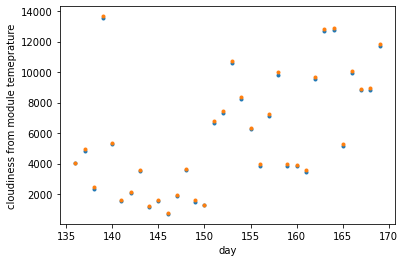

In [7]:
cloudiness_temp_v1=find_cloudiness_v1(weather_data, 'MODULE_TEMPERATURE')
cloudiness_temp_v2=find_cloudiness_v2(weather_data, 'MODULE_TEMPERATURE')
plt.figure()
plt.plot(cloudiness_temp_v1['DAY'], cloudiness_temp_v1['cloudiness'], '.')
plt.plot(cloudiness_temp_v2['DAY'], cloudiness_temp_v2['cloudiness'], '.')
plt.xlabel('day')
plt.ylabel('cloudiness from module temeprature')

Text(0, 0.5, 'cloudiness from irradiation')

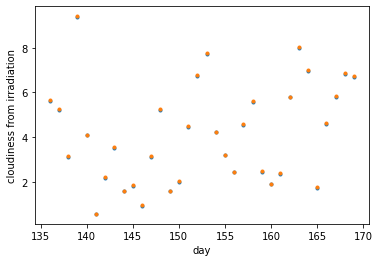

In [8]:
cloudiness_v1=find_cloudiness_v1(weather_data, 'IRRADIATION')
cloudiness_v2=find_cloudiness_v2(weather_data, 'IRRADIATION')
plt.figure()
plt.plot(cloudiness_v1['DAY'], cloudiness_v1['cloudiness'], '.')
plt.plot(cloudiness_v2['DAY'], cloudiness_v2['cloudiness'], '.')
plt.xlabel('day')
plt.ylabel('cloudiness from irradiation')

## Outlier functions

In [9]:
def get_outliers_in_time(data, column, groupby_column, output_column_name=False, outlier_limit=3):
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    for i, group in  data.groupby(groupby_column):
        outlier_condition1=group[column]>(group[group[column]>0][column].mean() + outlier_limit*group[group[column]>0][column].std())
        outlier_condition2=group[column]<(group[group[column]>0][column].mean() - outlier_limit*group[group[column]>0][column].std())
        data.loc[group[(outlier_condition1|outlier_condition2)&(group[group[column]>0][column].std()>0)].index, output_column_name]=1
    return data
def get_outliers_for_fit(data, x_column, y_column, groupby_column, output_column_name=False, window=False, outlier_limit=3):
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    data['gross_efficiency']=data[y_column]/data[x_column]
    for i, group in  data.groupby(groupby_column):
        resorted=group.reset_index().set_index('DATE_TIME').copy()
        outlier_condition1=resorted[resorted[y_column]>0]['gross_efficiency']>(resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).mean() + (outlier_limit+1)*resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).std())
        outlier_condition2=resorted[resorted[y_column]>0]['gross_efficiency']<(resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).mean() - outlier_limit*resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).std())            
        outlier_condition3=resorted[resorted[y_column]>0][x_column]>0.1*resorted[resorted[y_column]>0][x_column].rolling(window=window).max()
        data.loc[resorted[resorted[y_column]>0][(outlier_condition1|outlier_condition2)&outlier_condition3]['index'], output_column_name]=1
        data.loc[resorted[(resorted[y_column]==0)&(resorted[x_column]>0.1*resorted[x_column].rolling(window=window).max())]['index'], output_column_name]=1
    return data

Text(0, 0.5, 'DC_POWER')

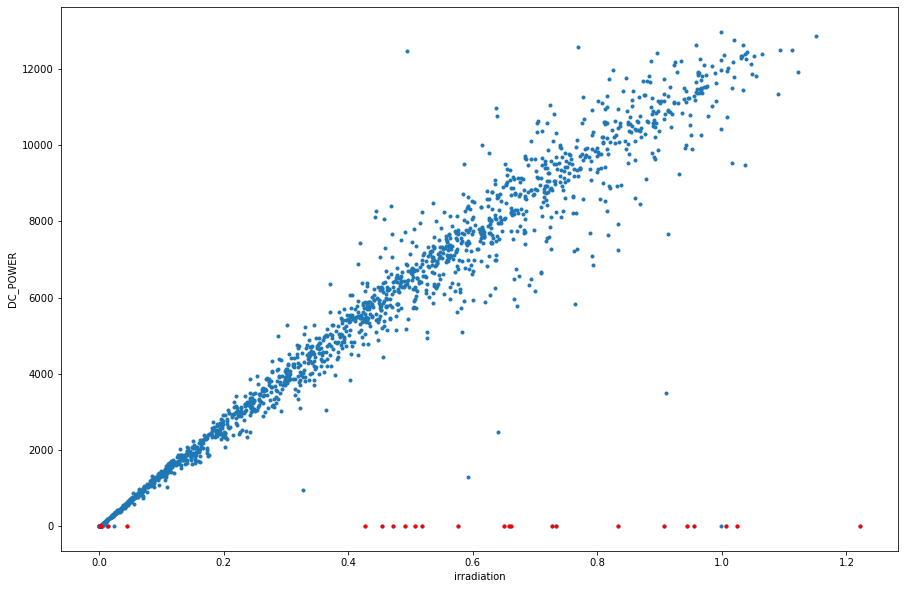

In [10]:
merged_df['DC_efficiency_gross']=merged_df['DC_POWER']/merged_df['IRRADIATION']
merged_df=get_outliers_in_time(merged_df, 'DC_efficiency_gross', ['TIME', 'DAY'], output_column_name="alarm_DC_conversion_outlier", outlier_limit=4)
inv0=merged_df[merged_df.SOURCE_KEY==merged_df.SOURCE_KEY.unique()[10]]
plt.figure(figsize=(15, 10))
plt.plot(inv0['IRRADIATION'], inv0['DC_POWER'], '.')
plt.plot(inv0[inv0["alarm_DC_conversion_outlier"]==1]['IRRADIATION'], inv0[inv0["alarm_DC_conversion_outlier"]==1]['DC_POWER'], 'r.')
plt.xlabel('irradiation')
plt.ylabel('DC_POWER')

Text(0, 0.5, 'DC_POWER')

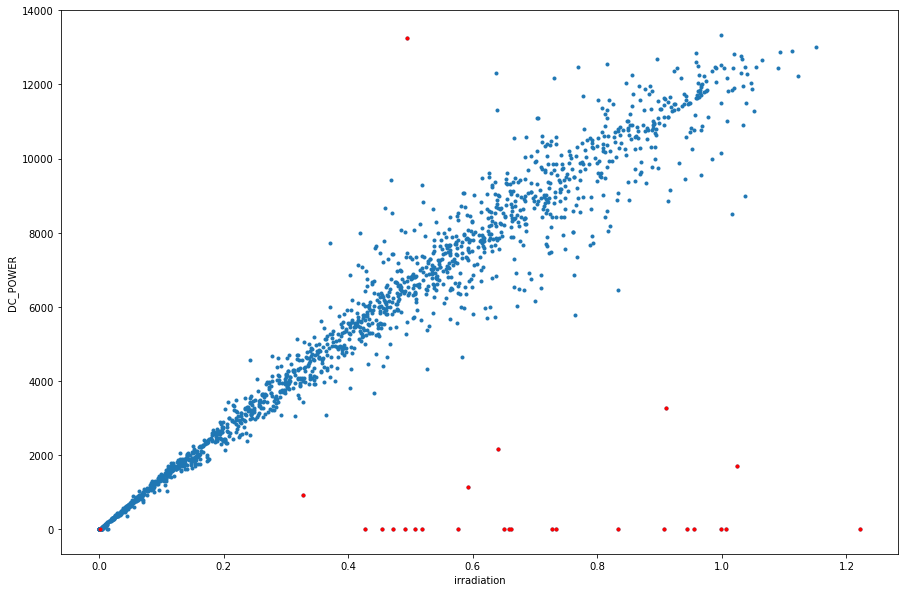

In [11]:
merged_df=get_outliers_for_fit(merged_df, 'IRRADIATION', 'DC_POWER', 'SOURCE_KEY', output_column_name="alarm_DC_conversion_outlier", window='7d', outlier_limit=4)
inv0=merged_df[merged_df.SOURCE_KEY==merged_df.SOURCE_KEY.unique()[0]]
plt.figure(figsize=(15, 10))
plt.plot(inv0['IRRADIATION'], inv0['DC_POWER'], '.')
plt.plot(inv0[inv0["alarm_DC_conversion_outlier"]==1]['IRRADIATION'], inv0[inv0["alarm_DC_conversion_outlier"]==1]['DC_POWER'], 'r.')
plt.xlabel('irradiation')
plt.ylabel('DC_POWER')

In [12]:
#function returns the data with the heighest and lowest residuals
def get_outliers_by_residual(data, x_column, y_column, output_column_name="residual_outliers", anomaly_limit=5):
    data[output_column_name]=0
    for i in data.SOURCE_KEY.unique():
        inv_data=data[data.SOURCE_KEY==i]
        for a, day in inv_data.groupby(inv_data.DAY):
            X = data[x_column].values.reshape(-1,1)
            y = data[y_column].values.reshape(-1,1)
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            m=regressor.coef_[0]
            residual=(day[y_column]-m*day[x_column])**2 # or we can take the absolute value
            mean_res = residual.mean()
            stand_dev = residual.std()
            data.loc[day[(residual>mean_res+anomaly_limit*stand_dev) | (residual<mean_res-anomaly_limit*stand_dev)].index, output_column_name] = 1
    return data

In [13]:
merged_df=get_outliers_by_residual(merged_df, 'DC_POWER', 'AC_POWER',output_column_name="alarm_AC_conversion_outlier", anomaly_limit=5)

Text(0.5, 1.0, 'AC vs. DC power')

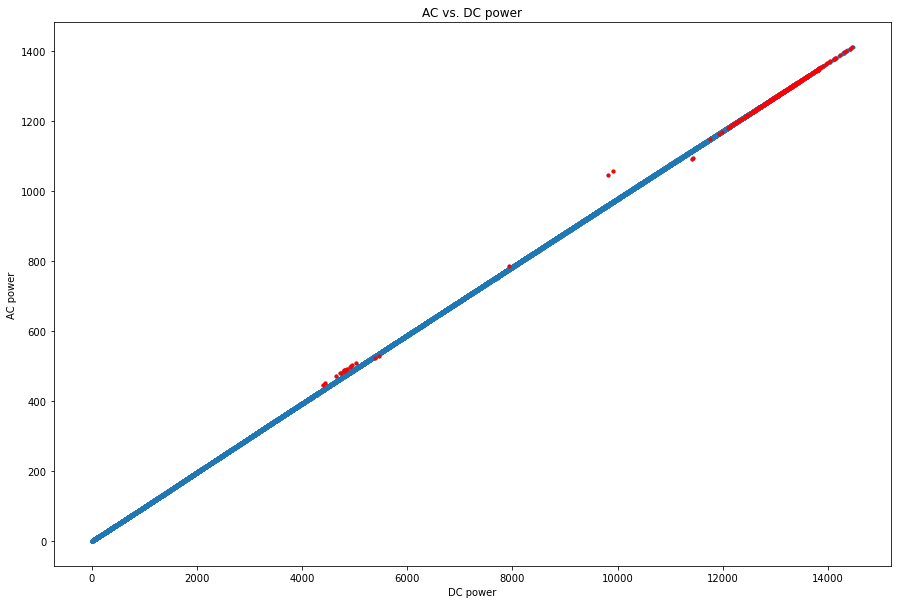

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(merged_df['DC_POWER'],merged_df['AC_POWER'], '.')
plt.plot(merged_df.loc[merged_df["alarm_AC_conversion_outlier"]==1, 'DC_POWER'],merged_df.loc[merged_df["alarm_AC_conversion_outlier"]==1,'AC_POWER'], 'r.')
plt.xlabel('DC power')
plt.ylabel('AC power')
plt.title('AC vs. DC power')

# Power conversion efficiency calculation (Irradiation to DC or DC to AC)

In [15]:
def get_conversion_coefficients(data, x_column, y_column, output_column_name="conversion_coefficient"):
    output_df=pd.DataFrame(columns=['SOURCE_KEY', 'DAY', output_column_name])
    for i in data.SOURCE_KEY.unique():
        inv_data=data[data.SOURCE_KEY==i]
        for a, day in inv_data.groupby(inv_data.DAY):
            X = day[x_column].values.reshape(-1,1)
            y = day[y_column].values.reshape(-1,1)
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            m=regressor.coef_[0][0]
            output_df=output_df.append(pd.DataFrame({'SOURCE_KEY': [i], 'DAY': [a], output_column_name: [m]}), ignore_index=True)
    return(output_df)

### DC generation

In [16]:
daily_data=get_conversion_coefficients(merged_df[(merged_df['MODULE_TEMPERATURE']<=50)&(merged_df["alarm_DC_conversion_outlier"]==0)], 'IRRADIATION', 'DC_POWER', output_column_name="DC_efficiency_unnorm")
daily_data['DC_efficiency']=daily_data['DC_efficiency_unnorm']/daily_data['DC_efficiency_unnorm'].max()
daily_data.head()

,SOURCE_KEY,DAY,DC_efficiency_unnorm,DC_efficiency
0,1BY6WEcLGh8j5v7,136,12654.292748,0.772615
1,1BY6WEcLGh8j5v7,137,13815.536158,0.843515
2,1BY6WEcLGh8j5v7,138,12746.229514,0.778228
3,1BY6WEcLGh8j5v7,139,13327.495955,0.813718
4,1BY6WEcLGh8j5v7,140,12703.448115,0.775616


Text(0, 0.5, 'inverter power generation efficiency')

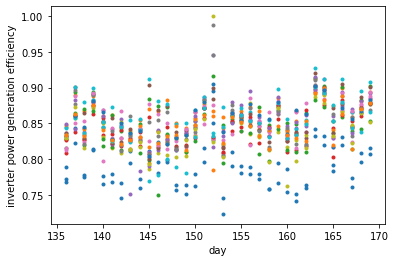

In [17]:
plt.figure()
for inv in daily_data.SOURCE_KEY.unique():
    plt.plot(daily_data[daily_data.SOURCE_KEY==inv]['DAY'], daily_data[daily_data.SOURCE_KEY==inv]['DC_efficiency'], '.', label=inv)
plt.xlabel('day')
plt.ylabel('inverter power generation efficiency')
#plt.legend()

### AC generation

In [18]:
daily_data_AC=get_conversion_coefficients(merged_df[(merged_df["alarm_AC_conversion_outlier"]==0)], 'DC_POWER', 'AC_POWER', output_column_name="AC_efficiency_unnorm")
daily_data_AC['AC_efficiency']=daily_data_AC['AC_efficiency_unnorm']/daily_data_AC['AC_efficiency_unnorm'].max()
daily_data.head()
daily_data=daily_data.merge(daily_data_AC, on=['SOURCE_KEY', 'DAY'])
daily_data.head()

,SOURCE_KEY,DAY,DC_efficiency_unnorm,DC_efficiency,AC_efficiency_unnorm,AC_efficiency
0,1BY6WEcLGh8j5v7,136,12654.292748,0.772615,0.097894,0.999364
1,1BY6WEcLGh8j5v7,137,13815.536158,0.843515,0.097882,0.999246
2,1BY6WEcLGh8j5v7,138,12746.229514,0.778228,0.097770,0.998107
3,1BY6WEcLGh8j5v7,139,13327.495955,0.813718,0.097893,0.999360
4,1BY6WEcLGh8j5v7,140,12703.448115,0.775616,0.097869,0.999115


Text(0, 0.5, 'inverter DC to AC conversion efficiency')

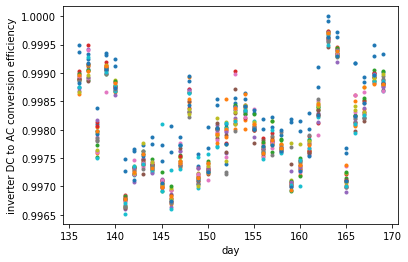

In [19]:
plt.figure()
for inv in daily_data_AC.SOURCE_KEY.unique():
    plt.plot(daily_data_AC[daily_data_AC.SOURCE_KEY==inv]['DAY'], daily_data_AC[daily_data_AC.SOURCE_KEY==inv]['AC_efficiency'], '.', label=inv)
plt.xlabel('day')
plt.ylabel('inverter DC to AC conversion efficiency')
#plt.legend()

# Detection of efficiency drops, trends, or inefficient behaviour compared to other inverters

In [20]:
def negative_trend_by_days(data, column, cloudiness, output_column_name, window=10, limit=-0.75):
    """
    Given a dataframe of inverter daily efficiencies calculates negative trends over a window of days. 
    Returns the dataframe with a new column, with 1 where the negative trend is below a certain limit.
    """
    data=data.merge(cloudiness, on='DAY')
    data['efficiency_trend']=0
    data['weather_trend']=0
    data[output_column_name]=0
    for inv in data.SOURCE_KEY.unique():
        data.loc[data.SOURCE_KEY==inv, 'efficiency_trend']=(data[data.SOURCE_KEY==inv]['DAY']/data[data.SOURCE_KEY==inv]['DAY'].max()).rolling(window=window).corr(data[data.SOURCE_KEY==inv][column]/data[data.SOURCE_KEY==inv][column].max())
        #data.loc[data.SOURCE_KEY==inv, 'weather_trend']=(data[data.SOURCE_KEY==inv][column]/data[data.SOURCE_KEY==inv][column].max()).rolling(window=window).corr(data[data.SOURCE_KEY==inv]['cloudiness']/data[data.SOURCE_KEY==inv]['cloudiness'].max())
    data.loc[(data['efficiency_trend']<=limit), output_column_name]=1
    ####
    return data.drop(columns=['efficiency_trend', 'weather_trend', 'cloudiness'])

In [21]:
daily_data=negative_trend_by_days(daily_data, 'DC_efficiency', cloudiness_v2, output_column_name='alarm_negative_trend', window=10, limit=-0.8)

In [22]:
daily_data=negative_trend_by_days(daily_data, 'DC_efficiency', cloudiness_temp_v2, output_column_name='alarm_negative_trend_temp', window=10, limit=-0.8)

In [23]:
daily_data.head()

,SOURCE_KEY,DAY,DC_efficiency_unnorm,DC_efficiency,AC_efficiency_unnorm,AC_efficiency,alarm_negative_trend,alarm_negative_trend_temp
0,1BY6WEcLGh8j5v7,136,12654.292748,0.772615,0.097894,0.999364,0,0
1,1IF53ai7Xc0U56Y,136,13565.308175,0.828237,0.097848,0.998894,0,0
2,3PZuoBAID5Wc2HD,136,13360.674324,0.815743,0.097846,0.998875,0,0
3,7JYdWkrLSPkdwr4,136,13241.189745,0.808448,0.097861,0.999036,0,0
4,McdE0feGgRqW7Ca,136,13695.649535,0.836195,0.097827,0.998686,0,0


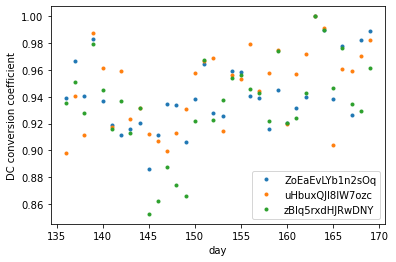

In [24]:
daily_data[daily_data['alarm_negative_trend']==1]
for inv in daily_data[daily_data['alarm_negative_trend']==1].SOURCE_KEY.unique():
    plt.plot(daily_data[daily_data.SOURCE_KEY==inv]['DAY'], daily_data[daily_data.SOURCE_KEY==inv]['DC_efficiency']/daily_data[daily_data.SOURCE_KEY==inv]['DC_efficiency'].max(), '.', label=inv)
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')
plt.legend()

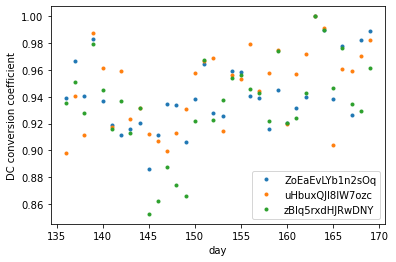

In [25]:
daily_data[daily_data['alarm_negative_trend_temp']==1]
for inv in daily_data[daily_data['alarm_negative_trend_temp']==1].SOURCE_KEY.unique():
    plt.plot(daily_data[daily_data.SOURCE_KEY==inv]['DAY'], daily_data[daily_data.SOURCE_KEY==inv]['DC_efficiency']/daily_data[daily_data.SOURCE_KEY==inv]['DC_efficiency'].max(), '.', label=inv)
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')
plt.legend()

In [26]:
daily_data=negative_trend_by_days(daily_data, 'AC_efficiency', cloudiness_v2, output_column_name='alarm_AC_negative_trend', window=10, limit=-0.6)

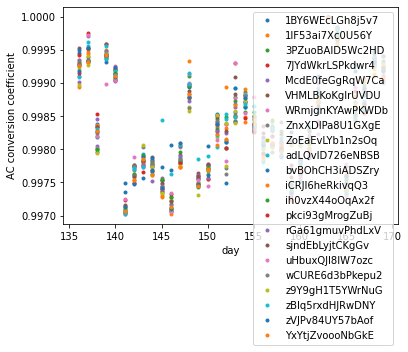

In [27]:
daily_data[daily_data['alarm_AC_negative_trend']==1]
for inv in daily_data[daily_data['alarm_AC_negative_trend']==1].SOURCE_KEY.unique():
    plt.plot(daily_data[daily_data.SOURCE_KEY==inv]['DAY'], daily_data[daily_data.SOURCE_KEY==inv]['AC_efficiency']/daily_data[daily_data.SOURCE_KEY==inv]['AC_efficiency'].max(), '.', label=inv)
plt.xlabel('day')
plt.ylabel('AC conversion coefficient')
plt.legend()

In [28]:
def efficiency_drop_by_day(data, column, outlier_coeff, drop_column_name, jump_column_name, window=20):
    """
    Given a dataframe of inverter daily efficiencies calculates efficiency jumps and falls relative to inverter history.
    """
    if drop_column_name:
        data[drop_column_name]=0
    if jump_column_name:
        data[jump_column_name]=0
    data['efficiency_lower_limit']=0
    data['efficiency_higher_limit']=0
    if window:
        for inv in data.SOURCE_KEY.unique():
            data.loc[data.SOURCE_KEY==inv, 'efficiency_lower_limit']=data[data.SOURCE_KEY==inv][column].rolling(window=window).median()-outlier_coeff*data[data.SOURCE_KEY==inv][column].rolling(window=window).std()
            data.loc[data.SOURCE_KEY==inv, 'efficiency_higher_limit']=data[data.SOURCE_KEY==inv][column].rolling(window=window).median()+outlier_coeff*data[data.SOURCE_KEY==inv][column].rolling(window=window).std()
    else:
        for inv in data.SOURCE_KEY.unique():
            data.loc[data.SOURCE_KEY==inv, 'efficiency_lower_limit']=data[data.SOURCE_KEY==inv][column].median()-outlier_coeff*data[data.SOURCE_KEY==inv][column].std()
            data.loc[data.SOURCE_KEY==inv, 'efficiency_higher_limit']=data[data.SOURCE_KEY==inv][column].median()+outlier_coeff*data[data.SOURCE_KEY==inv][column].std()
    if drop_column_name:
        data.loc[data[column]<data['efficiency_lower_limit'], drop_column_name]=1
    if jump_column_name:
        data.loc[data[column]>data['efficiency_higher_limit'], jump_column_name]=1
    return data.drop(columns=['efficiency_lower_limit', 'efficiency_higher_limit'])

Text(0, 0.5, 'DC conversion coefficient')

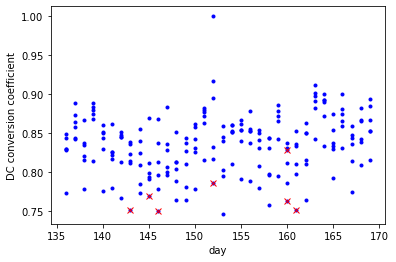

In [29]:
daily_data=efficiency_drop_by_day(daily_data, 'DC_efficiency', 2, 'alarm_DC_conversion_fall', 'alarm_DC_conversion_jump', window=7)
inverters=daily_data[daily_data['alarm_DC_conversion_fall']==1]['SOURCE_KEY'].unique()
data=daily_data[daily_data['SOURCE_KEY'].isin(inverters)]
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['DC_efficiency'], 'b.')
plt.plot(data[data.alarm_DC_conversion_fall==1]['DAY'], data[data.alarm_DC_conversion_fall==1]['DC_efficiency'], 'rx')
#plt.plot(data[data.alarm_DC_conversion_jump==1]['DAY'], data[data.alarm_DC_conversion_jump==1]['DC_efficiency'], 'gx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

Text(0, 0.5, 'AC conversion coefficient')

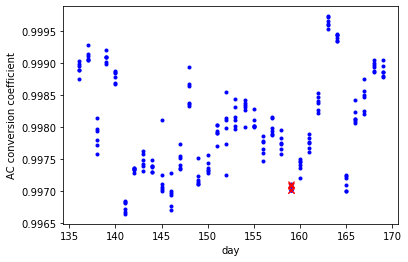

In [30]:
daily_data=efficiency_drop_by_day(daily_data, 'AC_efficiency', 2, 'alarm_AC_conversion_fall', 'alarm_AC_conversion_jump', window=7)
inverters=daily_data[daily_data['alarm_AC_conversion_fall']==1]['SOURCE_KEY'].unique()
data=daily_data[daily_data['SOURCE_KEY'].isin(inverters)]
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['AC_efficiency'], 'b.')
plt.plot(data[data.alarm_AC_conversion_fall==1]['DAY'], data[data.alarm_AC_conversion_fall==1]['AC_efficiency'], 'rx')
#plt.plot(data[data.alarm_AC_conversion_jump==1]['DAY'], data[data.alarm_AC_conversion_jump==1]['AC_efficiency'], 'gx')
plt.xlabel('day')
plt.ylabel('AC conversion coefficient')

In [31]:
#def low_efficiency_by_day

In [32]:
def get_inefficient_inverters_day(data, column, output_column_name, anomaly_limit = 2):
    data[output_column_name] = 0
    for _,d in data.groupby('DAY'):
        col_mean = d[column].mean()
        col_std = d[column].std()
        data.loc[d[(d[column] < col_mean - anomaly_limit * col_std)].index,output_column_name] = 1
    return data

Text(0, 0.5, 'DC conversion coefficient')

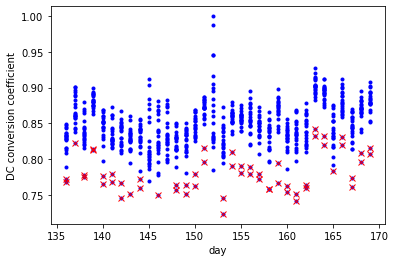

In [33]:
daily_data = get_inefficient_inverters_day(daily_data, 'DC_efficiency', 'alarm_inefficient_inverter_day')
data=daily_data
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['DC_efficiency'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_day==1]['DAY'], data[data.alarm_inefficient_inverter_day==1]['DC_efficiency'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

Text(0, 0.5, 'DC conversion coefficient')

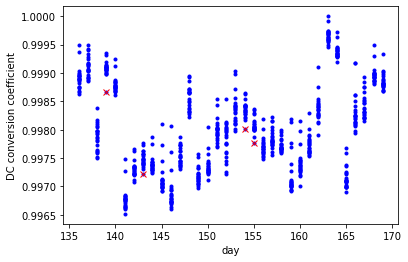

In [34]:
daily_data = get_inefficient_inverters_day(daily_data, 'AC_efficiency', 'alarm_AC_inefficient_inverter_day')
data=daily_data
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['AC_efficiency'], 'b.')
plt.plot(data[data.alarm_AC_inefficient_inverter_day==1]['DAY'], data[data.alarm_AC_inefficient_inverter_day==1]['AC_efficiency'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

In [35]:
data[data.alarm_inefficient_inverter_day==1]

,SOURCE_KEY,DAY,DC_efficiency_unnorm,DC_efficiency,AC_efficiency_unnorm,AC_efficiency,alarm_negative_trend,alarm_negative_trend_temp,alarm_AC_negative_trend,alarm_DC_conversion_fall,alarm_DC_conversion_jump,alarm_AC_conversion_fall,alarm_AC_conversion_jump,alarm_inefficient_inverter_day,alarm_AC_inefficient_inverter_day
0,1BY6WEcLGh8j5v7,136,12654.292748,0.772615,0.097894,0.999364,0,0,0,0,0,0,0,1,0
10,bvBOhCH3iADSZry,136,12568.021022,0.767347,0.097907,0.999502,0,0,0,0,0,0,0,1,0
32,bvBOhCH3iADSZry,137,13461.588435,0.821905,0.097891,0.999341,0,0,0,0,0,0,0,1,0
44,1BY6WEcLGh8j5v7,138,12746.229514,0.778228,0.097770,0.998107,0,0,0,0,0,0,0,1,0
54,bvBOhCH3iADSZry,138,12682.221744,0.774320,0.097797,0.998382,0,0,0,0,0,0,0,1,0
66,1BY6WEcLGh8j5v7,139,13327.495955,0.813718,0.097893,0.999360,0,0,0,0,0,0,0,1,0
76,bvBOhCH3iADSZry,139,13321.946101,0.813379,0.097889,0.999314,0,0,0,0,0,0,0,1,0
88,1BY6WEcLGh8j5v7,140,12703.448115,0.775616,0.097869,0.999115,0,0,0,0,0,0,0,1,0
98,bvBOhCH3iADSZry,140,12539.969387,0.765635,0.097882,0.999246,0,0,0,0,0,0,0,1,0
110,1BY6WEcLGh8j5v7,141,12762.982124,0.779251,0.097688,0.997267,0,0,0,0,0,0,0,1,0


In [36]:
#inefficiency in a window

In [37]:
def get_inefficient_inverters_window(data, column, output_column_name, window=7):
    data[output_column_name] = 0
    for inv in data['SOURCE_KEY'].unique():
        data.loc[data['SOURCE_KEY']==inv, output_column_name]=data[data['SOURCE_KEY']==inv][column].rolling(window = window).min()
    return data

Text(0, 0.5, 'DC conversion coefficient')

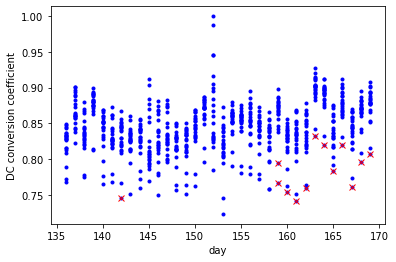

In [38]:
daily_data = get_inefficient_inverters_window(daily_data, 'alarm_inefficient_inverter_day', 'alarm_inefficient_inverter_window', window=7)
data=daily_data
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['DC_efficiency'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_window==1]['DAY'], data[data.alarm_inefficient_inverter_window==1]['DC_efficiency'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

Text(0, 0.5, 'DC conversion coefficient')

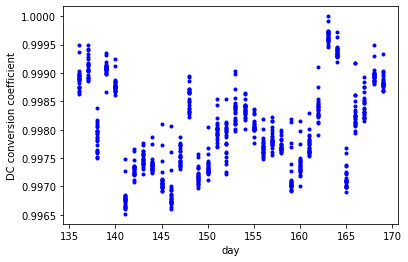

In [39]:
daily_data = get_inefficient_inverters_window(daily_data, 'alarm_AC_inefficient_inverter_day', 'alarm_AC_inefficient_inverter_window')
data=daily_data
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['AC_efficiency'], 'b.')
plt.plot(data[data.alarm_AC_inefficient_inverter_window==1]['DAY'], data[data.alarm_AC_inefficient_inverter_window==1]['AC_efficiency'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

In [40]:
merged_df.to_csv('../../data/processed_data/Plant_'+str(plant)+'_alarm_data.csv')
daily_data.to_csv('../../data/processed_data/Plant_'+str(plant)+'_efficiency_alarm_data.csv')

In [41]:
data[data.alarm_inefficient_inverter_window==1]

,SOURCE_KEY,DAY,DC_efficiency_unnorm,DC_efficiency,AC_efficiency_unnorm,AC_efficiency,alarm_negative_trend,alarm_negative_trend_temp,alarm_AC_negative_trend,alarm_DC_conversion_fall,alarm_DC_conversion_jump,alarm_AC_conversion_fall,alarm_AC_conversion_jump,alarm_inefficient_inverter_day,alarm_AC_inefficient_inverter_day,alarm_inefficient_inverter_window,alarm_AC_inefficient_inverter_window
142,bvBOhCH3iADSZry,142,12205.070956,0.745187,0.097723,0.997618,0,0,0,0,0,0,0,1,0,1.0,0.0
506,1BY6WEcLGh8j5v7,159,13017.566964,0.794795,0.097778,0.998181,0,0,0,0,0,0,0,1,0,1.0,0.0
516,bvBOhCH3iADSZry,159,12559.288359,0.766814,0.097773,0.998131,0,0,0,0,0,0,0,1,0,1.0,0.0
538,bvBOhCH3iADSZry,160,12346.333289,0.753812,0.097775,0.998153,0,0,1,0,0,0,0,1,0,1.0,0.0
560,bvBOhCH3iADSZry,161,12133.818491,0.740837,0.097788,0.998288,0,0,0,0,0,0,0,1,0,1.0,0.0
582,bvBOhCH3iADSZry,162,12436.674220,0.759328,0.097868,0.999098,0,0,0,0,0,0,1,1,0,1.0,0.0
604,bvBOhCH3iADSZry,163,13620.426050,0.831603,0.097956,1.000000,0,0,0,0,1,0,1,1,0,1.0,0.0
626,bvBOhCH3iADSZry,164,13431.064265,0.820041,0.097928,0.999719,0,0,0,0,0,0,0,1,0,1.0,0.0
648,bvBOhCH3iADSZry,165,12835.550770,0.783682,0.097721,0.997596,0,0,0,0,0,0,0,1,0,1.0,0.0
670,bvBOhCH3iADSZry,166,13418.392521,0.819267,0.097876,0.999183,0,0,0,0,0,0,0,1,0,1.0,0.0
